<a href="https://colab.research.google.com/github/Ronakb12/Dogs_vs_Cats_Binary_Classification/blob/main/Dogs_vs_Cats_Binary_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raw images to classification with Convolutional Neural Network #

We're going to be running through taking raw images that have been labeled for us already, and then feeding them through a convolutional neural network for classification. 

The images are either of dog(s) or cat(s). 

Once you have downloaded and extracted the data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data, you're ready to begin.

In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion

TRAIN_DIR = "\Kaggle\DogsCats\\train\\train"
TEST_DIR = "\Kaggle\DogsCats\\test"
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

Now, our first order of business is to convert the images and labels to array information that we can pass through our network. To do this, we'll need a helper function to convert the image name to an array. 

Our images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array like so:

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

Now, we can build another function to fully process the training images and their labels into arrays:

In [ ]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [ ]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

# Convolutional Neural Network

Next, we're ready to define our neural network:

In [3]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 4.7 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=f01cffee6832e75dd412135dcceb5f46e4b863e019256a4bcbd1dc6c96253897
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


Now, let's split out training and testing data:

In [ ]:
train = train_data[:-500]
test = train_data[-500:]

In [ ]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

First, we need to reset the graph instance, since we're doing this in a continuous environment:

In [ ]:
import tensorflow as tf
tf.compat.v1.reset_default_graph()


In [ ]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 4978  | total loss: 0.26346 | time: 23.466s
| Adam | epoch: 003 | loss: 0.26346 - acc: 0.9013 -- iter: 24448/24498
Training Step: 4979  | total loss: 0.26199 | time: 24.539s
| Adam | epoch: 003 | loss: 0.26199 - acc: 0.8987 | val_loss: 0.32292 - val_acc: 0.8560 -- iter: 24498/24498
--


WELL WELL WELL... Looks like we've got a winner. With neural networks, size matters a ton. We went from having apparently un-trainable data to having obviously trainable data, and this was only 3 epochs. 

If you are happy with the model, go ahead and save it:

In [ ]:
model.save(MODEL_NAME)

INFO:tensorflow:d:\FDM downloads\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


Now we can reload the model, and continue training (we don't NEED to reload the model here since this is continuous and the model is still in memory, but if you were running this as a program you would)

In [ ]:
model.load('/content/{}'.format(MODEL_NAME))

INFO:tensorflow:Restoring parameters from /content/dogsvscats-0.001-2conv-basic.model


In [ ]:
CARTEGORIES = ["Dog","Cat"]

def prepare(filepath):
    IMG_SIZE = 50
    img_array= cv2.imread(filepath,cv2.IMREAD_GRAYSCALE)
    # cv2.imshow("img",img_array)
    new_array= cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,1)

# model= tf.keras.models.load_model("D:\FDM downloads\\test_data.npy")
filepath = "/content/img1.jpg"
prediction = model.predict(prepare(filepath))
#always predict in a list even for a single thing
print(prediction)




[[9.9996436e-01 3.5645880e-05]]


Cat


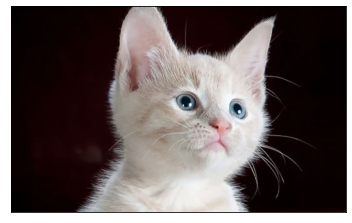

In [ ]:
import matplotlib.pyplot as plt

img_array= cv2.imread(filepath)
img_array= cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
fig= plt.imshow(img_array)
fig.set_cmap('hot')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
if prediction[0][0]>prediction[0][1]:
    print("Cat")
else:
    print("Dog")